# Spam emails filter

## Data exploration

In [1]:
import os

cwd = os.getcwd()
DATA_DIR = os.path.join(cwd, "data")

The dataset is divided into examples of two groups of emails: `spam` and not spam `clean`.

In [2]:
os.listdir(DATA_DIR)

['spam', 'all', 'clean']

In [3]:
def get_filenames(dir_name):
    return [name for name in sorted(os.listdir(dir_name))]

In [4]:

clean_filesnames = get_filenames(os.path.join(DATA_DIR, 'clean'))
spam_filenames = get_filenames(os.path.join(DATA_DIR, 'spam'))


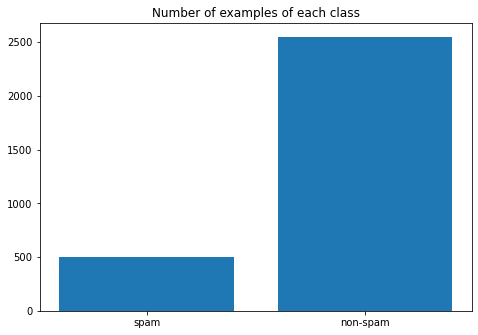

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(["spam", "non-spam"],[len(spam_filenames), len(clean_filesnames)])

plt.title("Number of examples of each class")
plt.show()

The dataset mostly consists of `non-spam` emails.

In [6]:
import email
import email.policy

ALL_EMAILS_DIR = os.path.join(DATA_DIR, "all")

def load_email(filename):
    with open(os.path.join(ALL_EMAILS_DIR, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [7]:
from random import randrange

example_spam_email = load_email(spam_filenames[randrange(len(spam_filenames))])


Let's see an example of spam email.

In [8]:
print('Header Field Names:\n',example_spam_email.keys())

Header Field Names:
 ['Return-Path', 'Delivery-Date', 'Return-Path', 'Received', 'Received', 'Received', 'To', 'From', 'Subject', 'Date', 'Message-Id', 'MIME-Version', 'Content-Type', 'Content-Transfer-Encoding', 'X-Server', 'X-Virus-Scanned', 'Status', 'X-Status', 'X-Keywords', 'X-UID']


In [9]:

print('Subject:\n',example_spam_email['Subject'])


Subject:
 11th Convergence India 2003 exhibition & conference


In [10]:
print('Message Field Values:\n',example_spam_email.values())

Message Field Values:
 ['ler@lerami.lerctr.org', 'Wed Sep  4 06:56:09 2002', '<exhibitionsindia@vsnl.com>', 'from localhost.localdomain ([202.88.149.8])\tby lerami.lerctr.org (8.12.2/8.12.2/20020902/$Revision: 1.30 $) with ESMTP id g84Bu1X2026577\tfor <ler@lerctr.org>; Wed, 4 Sep 2002 06:56:05 -0500 (CDT)', 'from server ([202.88.149.167])\tby localhost.localdomain (8.9.3/8.8.7) with ESMTP id QAA07716\tfor <ler@lerctr.org>; Wed, 4 Sep 2002 16:54:03 +0530', 'from 10.0.0.6 by server ([10.0.0.1] running VPOP3) with SMTP for <ler@lerctr.org>; Wed, 4 Sep 2002 16:50:10 +0530', 'ler@lerctr.org', 'Deepak Nagpal <exhibitionsindia@vsnl.com>', '11th Convergence India 2003 exhibition & conference', 'Wed, 04 Sep 2002 16:55:29 +0530', '<37503.705196875002000.233756@localhost>', '1.0', 'text/html; charset="us-ascii"', '8bit', 'VPOP3 V1.3.0b - Registered to: The GodFader', 'by amavisd-milter (http://amavis.org/)', 'RO', '', '', '4']


In [11]:
print('Message Content:\n',example_spam_email.get_content())

Message Content:
 <HTML><HEAD>
<META http-equiv=Content-Type content="text/html;
charset=iso-8859-1">
<META content="MSHTML 5.50.4134.600" name=GENERATOR>
<STYLE></STYLE>
</HEAD>
<BODY bgColor=#ffffff>
<DIV><FONT face=Arial size=2>Dear Sir/Madam,</FONT></DIV>
<DIV><FONT face=Arial size=2></FONT>&nbsp;</DIV>
<DIV><FONT face=Arial size=2>I got this email id from your
website.</FONT></DIV>
<DIV><FONT face=Arial size=2></FONT>&nbsp;</DIV>
<DIV align=justify><FONT face=Arial size=2>Our organisation,
Exhibitions India 
Pvt Ltd organises the annual Convergence India exhibition and
conference in New 
Delhi, India during the month of March. <STRONG>Convergence
India is the longest 
running international trade-show</STRONG> and the only forum
in India to 
showcase the convergence of voice and data networks, delivery
of content, 
television and entertainment applications, broadcast,
telecommunications, fixed 
and mobile networks, internet, computing etc.</FONT></DIV>
<DIV><FONT face=Arial size=2>

## Data preparation

First we need to prepare the training and test `dataset` for our model.

In [12]:
print("Importing clean mails\n")
clean_emails = [load_email(email) for email in clean_filesnames]
print("\nImporting spam mails\n")
spam_emails = [load_email(email) for email in spam_filenames]


Importing clean mails


Importing spam mails



### Struture of emails

In [15]:
from collections import Counter

def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures


In [16]:
clean_structures = structures_counter(clean_emails)
print("Clean mails structure:\n", clean_structures)

Clean mails structure:
 Counter({'text/plain': 2453, 'multipart(text/plain, application/pgp-signature)': 72, 'multipart(text/plain, text/html)': 8, 'multipart(text/plain, text/plain)': 4, 'multipart(text/plain)': 3, 'multipart(text/plain, application/octet-stream)': 2, 'multipart(text/plain, text/enriched)': 1, 'multipart(text/plain, application/ms-tnef, text/plain)': 1, 'multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)': 1, 'multipart(text/plain, video/mng)': 1, 'multipart(text/plain, multipart(text/plain))': 1, 'multipart(text/plain, application/x-pkcs7-signature)': 1, 'multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)': 1, 'multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))': 1, 'multipart(text/plain, application/x-java-applet)': 1})


In [17]:
spam_structures = structures_counter(spam_emails)
print("Clean mails structure:\n", spam_structures)

Clean mails structure:
 Counter({'text/plain': 222, 'text/html': 181, 'multipart(text/plain, text/html)': 45, 'multipart(text/html)': 19, 'multipart(text/plain)': 19, 'multipart(multipart(text/html))': 5, 'multipart(text/plain, image/jpeg)': 3, 'multipart(text/html, application/octet-stream)': 2, 'multipart(text/plain, application/octet-stream)': 1, 'multipart(text/html, text/plain)': 1, 'multipart(multipart(text/html), application/octet-stream, image/jpeg)': 1, 'multipart(multipart(text/plain, text/html), image/gif)': 1, 'multipart/alternative': 1})


/usr/local/anaconda3/envs/CI/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


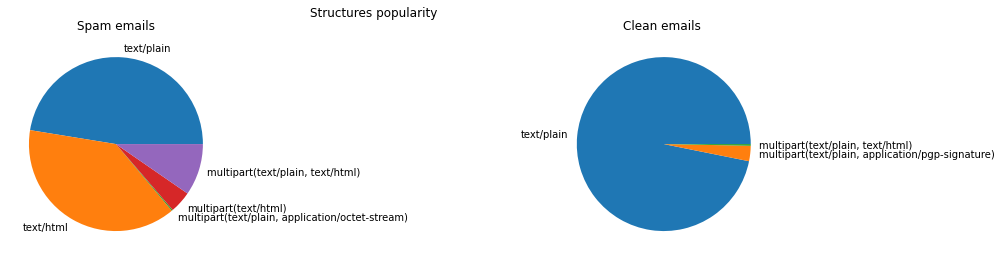

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Structures popularity')

ax1.pie(list(spam_structures.values())[:5],labels=list(spam_structures.keys())[:5])
ax1.set_title("Spam emails")
ax1.plot()

ax2.pie(list(clean_structures.values())[:3],labels=list(clean_structures.keys())[:3])
ax2.set_title("Clean emails ")
ax2.plot() 

fig.set_figwidth(18)
fig.show()

As we can see in the plot above, spam emails consist mostly of plain text content while in the spam emails html and multipart structures are more common. 

### Converting email contents to plain text